## MNIST classification NN

In [2]:
import torch
import random
import torchvision
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

In [16]:
dataset = torchvision.datasets.MNIST("data", download=True)

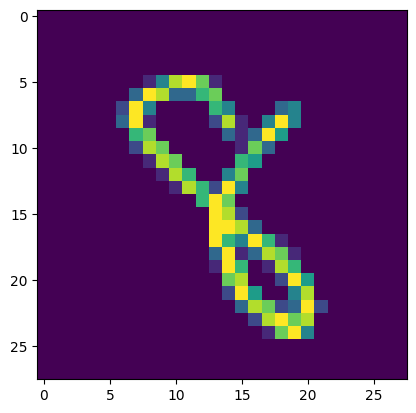

In [28]:
plt.imshow(random.choice(dataset.data))

In [30]:
class MNISTClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        pass
    def forward(self):
        pass